<a href="https://colab.research.google.com/github/seeedata/BADA/blob/main/%ED%96%89%EC%82%AC%20%EC%B0%B8%EC%97%AC%20%EC%9D%B8%EC%9B%90%20%EC%98%88%EC%B8%A1%EC%9D%84%20%ED%86%B5%ED%95%9C%20%EC%95%88%EC%A0%84%20%EA%B4%80%EB%A6%AC%20%EC%BB%A8%EC%84%A4%ED%8C%85%20%EC%84%9C%EB%B9%84%EC%8A%A4/0725%20%EC%A7%80%ED%95%98%EC%B2%A0%20data%20%EC%A0%84%EC%B2%98%EB%A6%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#import

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [ ]:
!pip install pyspark
!pip install tslearn

import datetime
import collections
import folium

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'NanumBarunGothic'

from pyspark.sql.functions import *
from pyspark.sql.types import *

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

from tslearn.clustering import TimeSeriesKMeans

import warnings
warnings.filterwarnings('ignore')

#데이터 불러오기

In [ ]:
sub=pd.read_csv('/content/drive/MyDrive/colab_data/지하철최종데이터.csv', encoding='cp949')
sub=sub.loc[(sub['날짜']<='2023-03-31'),:]
sub['날짜']=pd.to_datetime(sub['날짜'])
sub=sub.drop(['03~04'],axis=1)
sub

,날짜,호선,역명,구분,00~01,01~02,02~03,04~05,05~06,06~07,...,14~15,15~16,16~17,17~18,18~19,19~20,20~21,21~22,22~23,23~24
0,2018-12-01,8,몽촌토성,승차,0,0,0,0,59,105,...,382,435,484,462,378,257,178,216,231,96
1,2018-12-01,8,몽촌토성,하차,9,0,0,0,29,151,...,433,441,501,499,448,249,198,235,200,106
2,2018-12-01,9,올림픽공원,순승차,0,0,0,4,20,40,...,348,431,484,431,328,165,145,1059,4448,245
3,2018-12-01,9,올림픽공원,순하차,4,0,0,4,3,46,...,640,831,1225,2047,2053,287,192,193,241,151
4,2018-12-01,5,올림픽공원,승차,1,0,0,0,25,87,...,287,286,383,338,249,168,126,182,1281,84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14475,2023-03-31,9,올림픽공원,순하차,109,3,0,0,26,197,...,449,483,626,1051,2174,1909,462,392,426,298
14476,2023-03-31,5,올림픽공원,승차,10,0,0,0,39,215,...,338,451,375,497,490,238,161,111,518,86
14477,2023-03-31,5,올림픽공원,하차,51,0,0,0,24,148,...,250,275,276,489,614,468,215,199,152,142
14478,2023-03-31,9,한성백제,순승차,7,0,0,0,36,117,...,123,177,207,241,384,153,118,82,75,48


# 결측치 확인

In [ ]:
findnull = pd.DataFrame(sub.groupby('날짜').count()['구분'])
findnull

,구분
날짜,
2018-12-01,10
2018-12-02,10
2018-12-03,10
2018-12-04,10
2018-12-05,10
...,...
2023-03-27,8
2023-03-28,8
2023-03-29,8


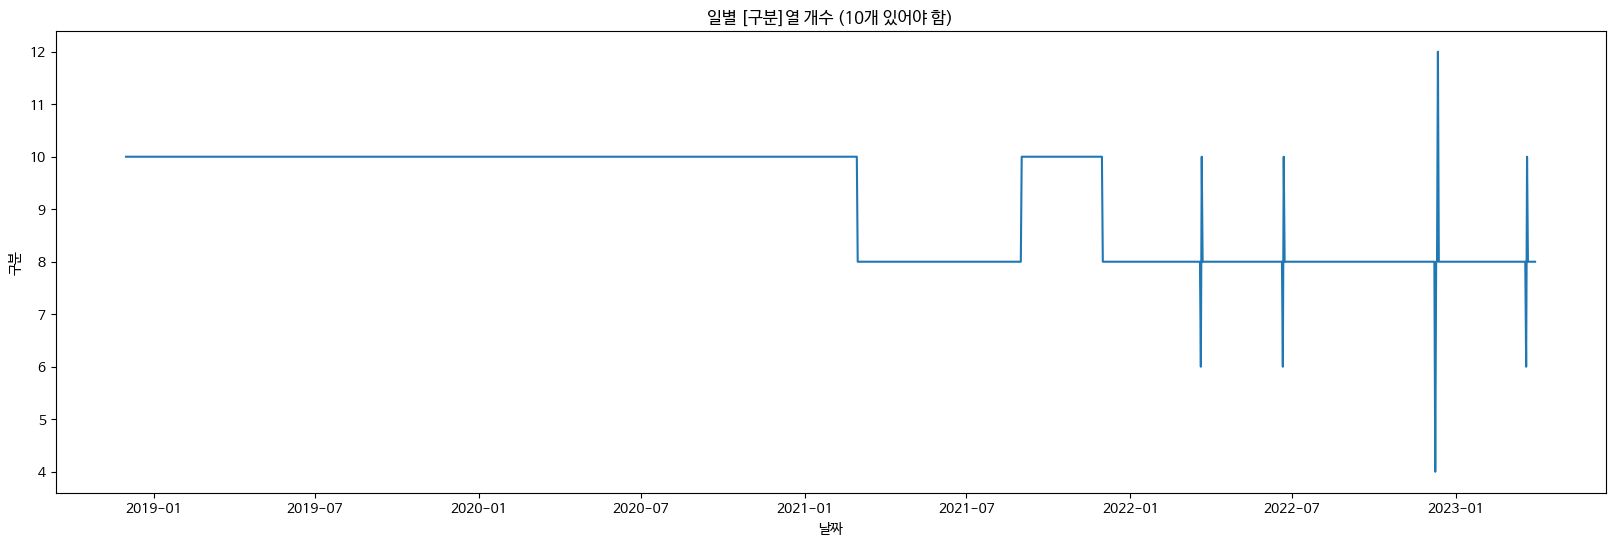

In [ ]:
plt.figure(figsize=(20,6))
plt.title('일별 [구분]열 개수 (10개 있어야 함)')
sns.lineplot(x=findnull.index, y='구분', data=findnull)
plt.show()

2021년 3월 1일 ~ 8월 31 환승승차, 환승하차 없음

2021년 12월 1일 ~ 2022년 3월 20일 환승승차, 환승하차 없음

2022년 3월 21일 환승승차, 환승하차, 올림픽 순하차, 한성백제 순하차 없음

2022년 3월 22일 데이터 이상함!!

2022년 3월 23일 ~ 2023년 6월 20일 환승승차, 환승하차 없음

2022년 6월 21일 올림픽 순하차, 환승승차, 환승하차, 한성백제 순하차 없음

2022년 6월 22일 데이터 이상함!!

2022년 12월 9일 올림픽 순하차, 순승차, 환승승차, 환승하차, 한성백제 순승차, 순하차 없음

2022년 12월 10일 ~ 2022년 12월 11일 환승승차, 환승하차 없음

2022년 12월 12일 데이터 이상함!!

2022년 12월 13일 ~ 2023년 3월 20일 환승승차, 환승하차 없음

2023년 3월 21일 올림픽 순하차, 환승승차, 환승하차, 한성백제 순하차 없음

2023년 3월 22일 데이터 이상함!!



환승승차, 환승하차 데이터 결측치가 너무 많아서 이를 아예 제외한다. 즉, 구분이 순승차, 순하차, 승차, 하차인 데이터로만 분석하자.

In [ ]:
sub=sub.loc[(sub['구분']=='순승차')|(sub['구분']=='순하차')|(sub['구분']=='승차')|(sub['구분']=='하차'), :]
sub

,날짜,호선,역명,구분,00~01,01~02,02~03,04~05,05~06,06~07,...,14~15,15~16,16~17,17~18,18~19,19~20,20~21,21~22,22~23,23~24
0,2018-12-01,8,몽촌토성,승차,0,0,0,0,59,105,...,382,435,484,462,378,257,178,216,231,96
1,2018-12-01,8,몽촌토성,하차,9,0,0,0,29,151,...,433,441,501,499,448,249,198,235,200,106
2,2018-12-01,9,올림픽공원,순승차,0,0,0,4,20,40,...,348,431,484,431,328,165,145,1059,4448,245
3,2018-12-01,9,올림픽공원,순하차,4,0,0,4,3,46,...,640,831,1225,2047,2053,287,192,193,241,151
4,2018-12-01,5,올림픽공원,승차,1,0,0,0,25,87,...,287,286,383,338,249,168,126,182,1281,84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14475,2023-03-31,9,올림픽공원,순하차,109,3,0,0,26,197,...,449,483,626,1051,2174,1909,462,392,426,298
14476,2023-03-31,5,올림픽공원,승차,10,0,0,0,39,215,...,338,451,375,497,490,238,161,111,518,86
14477,2023-03-31,5,올림픽공원,하차,51,0,0,0,24,148,...,250,275,276,489,614,468,215,199,152,142
14478,2023-03-31,9,한성백제,순승차,7,0,0,0,36,117,...,123,177,207,241,384,153,118,82,75,48


In [ ]:
findnull2 = pd.DataFrame(sub.groupby('날짜').count()['구분'])
findnull2

,구분
날짜,
2018-12-01,8
2018-12-02,8
2018-12-03,8
2018-12-04,8
2018-12-05,8
...,...
2023-03-27,8
2023-03-28,8
2023-03-29,8


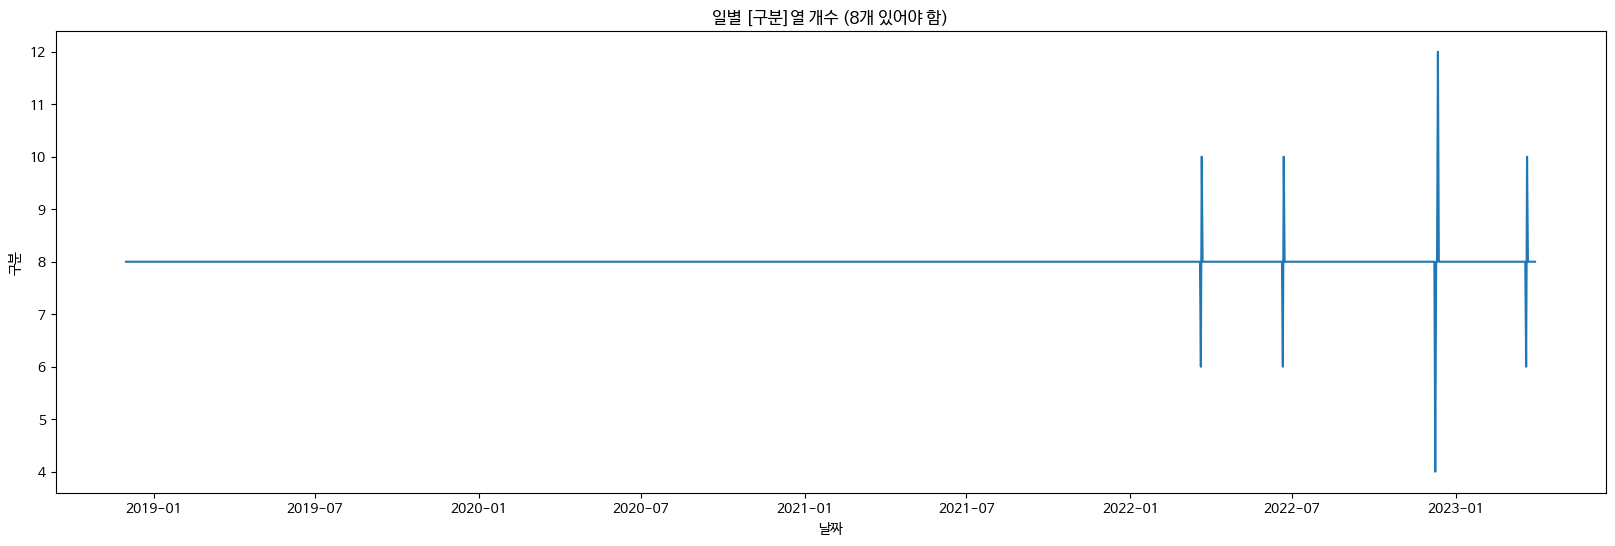

In [ ]:
plt.figure(figsize=(20,6))
plt.title('일별 [구분]열 개수 (8개 있어야 함)')
sns.lineplot(x=findnull2.index, y='구분', data=findnull2)
plt.show()



1. 2022년 3월 21일 올림픽 순하차, 한성백제 순하차 없음

2. 2022년 3월 22일 데이터 이상함!!

3. 2022년 6월 21일 올림픽 순하차, 한성백제 순하차 없음

4. 2022년 6월 22일 데이터 이상함!!

5. 2022년 12월 9일 올림픽 순하차, 순승차, 한성백제 순승차, 순하차 없음

6. 2022년 12월 12일 데이터 이상함!!

7. 2023년 3월 21일 올림픽 순하차, 한성백제 순하차 없음

8. 2023년 3월 22일 데이터 이상함!!


결측치 대체 방법: Simple Moving Average (n=30)

이전 30일 간의 평균을 구해 결측치에 채워넣는다.

In [ ]:
#1. 2022년 3월 21일 올림픽 순하차, 한성백제 순하차 없음
mean_올림픽순하차 = sub.loc[(sub['역명']=='올림픽공원')&(sub['호선']==9)&(sub['구분']=='순하차')].loc[(sub['날짜']>='2022-02-19')&(sub['날짜']<='2022-03-20')].mean()[1:]
mean_올림픽순하차 = list((np.round(mean_올림픽순하차,0)).astype('int64'))
mean_한성순하차 = sub.loc[(sub['역명']=='한성백제')&(sub['호선']==9)&(sub['구분']=='순하차')].loc[(sub['날짜']>='2022-02-19')&(sub['날짜']<='2022-03-20')].mean()[1:]
mean_한성순하차 = list((np.round(mean_한성순하차,0)).astype('int64'))
print(len(mean_올림픽순하차),len(mean_한성순하차))

23 23


In [ ]:
new_올림픽순하차 = [pd.to_datetime('2022-03-21'), 9, '올림픽공원', '순하차'] + mean_올림픽순하차
new_한성순하차 = [pd.to_datetime('2022-03-21'), 9, '한성백제', '순하차'] + mean_한성순하차
sub.loc[14480] = new_올림픽순하차
sub.loc[14481] = new_한성순하차
sub.tail()

,날짜,호선,역명,구분,00~01,01~02,02~03,04~05,05~06,06~07,...,14~15,15~16,16~17,17~18,18~19,19~20,20~21,21~22,22~23,23~24
14477,2023-03-31,5,올림픽공원,하차,51,0,0,0,24,148,...,250,275,276,489,614,468,215,199,152,142
14478,2023-03-31,9,한성백제,순승차,7,0,0,0,36,117,...,123,177,207,241,384,153,118,82,75,48
14479,2023-03-31,9,한성백제,순하차,61,0,0,0,7,50,...,146,133,150,263,322,279,143,124,129,98
14480,2022-03-21,9,올림픽공원,순하차,6,0,0,0,14,110,...,244,309,337,402,517,382,244,231,262,108
14481,2022-03-21,9,한성백제,순하차,2,0,0,0,6,32,...,94,88,94,124,183,162,89,84,86,50


In [ ]:
#3. 2022년 6월 21일 올림픽 순하차, 한성백제 순하차 없음
mean_올림픽순하차 = sub.loc[(sub['역명']=='올림픽공원')&(sub['호선']==9)&(sub['구분']=='순하차')].loc[(sub['날짜']>='2022-05-22')&(sub['날짜']<='2022-06-20')].mean()[1:]
mean_올림픽순하차 = list((np.round(mean_올림픽순하차,0)).astype('int64'))
mean_한성순하차 = sub.loc[(sub['역명']=='한성백제')&(sub['호선']==9)&(sub['구분']=='순하차')].loc[(sub['날짜']>='2022-05-22')&(sub['날짜']<='2022-06-20')].mean()[1:]
mean_한성순하차 = list((np.round(mean_한성순하차,0)).astype('int64'))
print(len(mean_올림픽순하차),len(mean_한성순하차))

23 23


In [ ]:
new_올림픽순하차 = [pd.to_datetime('2022-06-21'), 9, '올림픽공원', '순하차'] + mean_올림픽순하차
new_한성순하차 = [pd.to_datetime('2022-06-21'), 9, '한성백제', '순하차'] + mean_한성순하차
sub.loc[14482] = new_올림픽순하차
sub.loc[14483] = new_한성순하차
sub.tail()

,날짜,호선,역명,구분,00~01,01~02,02~03,04~05,05~06,06~07,...,14~15,15~16,16~17,17~18,18~19,19~20,20~21,21~22,22~23,23~24
14479,2023-03-31,9,한성백제,순하차,61,0,0,0,7,50,...,146,133,150,263,322,279,143,124,129,98
14480,2022-03-21,9,올림픽공원,순하차,6,0,0,0,14,110,...,244,309,337,402,517,382,244,231,262,108
14481,2022-03-21,9,한성백제,순하차,2,0,0,0,6,32,...,94,88,94,124,183,162,89,84,86,50
14482,2022-06-21,9,올림픽공원,순하차,41,0,0,0,21,137,...,455,487,484,553,676,559,370,315,344,202
14483,2022-06-21,9,한성백제,순하차,17,0,0,0,8,42,...,114,111,127,160,236,192,111,102,103,73


In [ ]:
#5. 2022년 12월 9일 올림픽 순하차, 순승차, 한성백제 순승차, 순하차 없음
mean_올림픽순하차 = sub.loc[(sub['역명']=='올림픽공원')&(sub['호선']==9)&(sub['구분']=='순하차')].loc[(sub['날짜']>='2022-11-09')&(sub['날짜']<='2022-12-08')].mean()[1:]
mean_올림픽순하차 = list((np.round(mean_올림픽순하차,0)).astype('int64'))
mean_한성순하차 = sub.loc[(sub['역명']=='한성백제')&(sub['호선']==9)&(sub['구분']=='순하차')].loc[(sub['날짜']>='2022-11-09')&(sub['날짜']<='2022-12-08')].mean()[1:]
mean_한성순하차 = list((np.round(mean_한성순하차,0)).astype('int64'))
mean_올림픽순승차 = sub.loc[(sub['역명']=='올림픽공원')&(sub['호선']==9)&(sub['구분']=='순승차')].loc[(sub['날짜']>='2022-11-09')&(sub['날짜']<='2022-12-08')].mean()[1:]
mean_올림픽순승차 = list((np.round(mean_올림픽순승차,0)).astype('int64'))
mean_한성순승차 = sub.loc[(sub['역명']=='한성백제')&(sub['호선']==9)&(sub['구분']=='순승차')].loc[(sub['날짜']>='2022-11-09')&(sub['날짜']<='2022-12-08')].mean()[1:]
mean_한성순승차 = list((np.round(mean_한성순승차,0)).astype('int64'))
new_올림픽순하차 = [pd.to_datetime('2022-12-09'), 9, '올림픽공원', '순하차'] + mean_올림픽순하차
new_한성순하차 = [pd.to_datetime('2022-12-09'), 9, '한성백제', '순하차'] + mean_한성순하차
new_올림픽순승차 = [pd.to_datetime('2022-12-09'), 9, '올림픽공원', '순승차'] + mean_올림픽순승차
new_한성순승차 = [pd.to_datetime('2022-12-09'), 9, '한성백제', '순승차'] + mean_한성순승차
sub.loc[14484] = new_올림픽순하차
sub.loc[14485] = new_한성순하차
sub.loc[14486] = new_올림픽순승차
sub.loc[14487] = new_한성순승차
sub.tail(8)

,날짜,호선,역명,구분,00~01,01~02,02~03,04~05,05~06,06~07,...,14~15,15~16,16~17,17~18,18~19,19~20,20~21,21~22,22~23,23~24
14480,2022-03-21,9,올림픽공원,순하차,6,0,0,0,14,110,...,244,309,337,402,517,382,244,231,262,108
14481,2022-03-21,9,한성백제,순하차,2,0,0,0,6,32,...,94,88,94,124,183,162,89,84,86,50
14482,2022-06-21,9,올림픽공원,순하차,41,0,0,0,21,137,...,455,487,484,553,676,559,370,315,344,202
14483,2022-06-21,9,한성백제,순하차,17,0,0,0,8,42,...,114,111,127,160,236,192,111,102,103,73
14484,2022-12-09,9,올림픽공원,순하차,63,0,0,0,20,149,...,426,537,664,802,896,640,390,338,336,200
14485,2022-12-09,9,한성백제,순하차,26,0,0,0,8,42,...,124,121,134,175,265,216,125,114,105,63
14486,2022-12-09,9,올림픽공원,순승차,5,0,0,0,59,247,...,327,384,505,558,740,302,735,679,377,99
14487,2022-12-09,9,한성백제,순승차,4,0,0,0,34,94,...,141,146,178,213,274,101,94,81,50,18


In [ ]:
#7. 2023년 3월 21일 올림픽 순하차, 한성백제 순하차 없음
mean_올림픽순하차 = sub.loc[(sub['역명']=='올림픽공원')&(sub['호선']==9)&(sub['구분']=='순하차')].loc[(sub['날짜']>='2023-02-19')&(sub['날짜']<='2023-03-20')].mean()[1:]
mean_올림픽순하차 = list((np.round(mean_올림픽순하차,0)).astype('int64'))
mean_한성순하차 = sub.loc[(sub['역명']=='한성백제')&(sub['호선']==9)&(sub['구분']=='순하차')].loc[(sub['날짜']>='2023-02-19')&(sub['날짜']<='2023-03-20')].mean()[1:]
mean_한성순하차 = list((np.round(mean_한성순하차,0)).astype('int64'))
new_올림픽순하차 = [pd.to_datetime('2023-03-21'), 9, '올림픽공원', '순하차'] + mean_올림픽순하차
new_한성순하차 = [pd.to_datetime('2023-03-21'), 9, '한성백제', '순하차'] + mean_한성순하차
sub.loc[14488] = new_올림픽순하차
sub.loc[14489] = new_한성순하차
sub.tail()

,날짜,호선,역명,구분,00~01,01~02,02~03,04~05,05~06,06~07,...,14~15,15~16,16~17,17~18,18~19,19~20,20~21,21~22,22~23,23~24
14485,2022-12-09,9,한성백제,순하차,26,0,0,0,8,42,...,124,121,134,175,265,216,125,114,105,63
14486,2022-12-09,9,올림픽공원,순승차,5,0,0,0,59,247,...,327,384,505,558,740,302,735,679,377,99
14487,2022-12-09,9,한성백제,순승차,4,0,0,0,34,94,...,141,146,178,213,274,101,94,81,50,18
14488,2023-03-21,9,올림픽공원,순하차,60,1,0,0,19,164,...,586,738,725,822,797,697,387,340,343,212
14489,2023-03-21,9,한성백제,순하차,27,0,0,0,8,40,...,114,117,125,169,255,220,123,115,107,63


In [ ]:
#2. 2022년 3월 22일 데이터 이상함!!
#올림픽 순하차 2개, 한성백제 순하차 2개 제거
drop_올림픽순하차 = sub.loc[
    (sub['역명']=='올림픽공원')&
     (sub['호선']==9)&
      (sub['구분']=='순하차')&
       (sub['날짜']=='2022-03-22')]
drop_한성순하차 = sub.loc[
    (sub['역명']=='한성백제')&
     (sub['호선']==9)&
      (sub['구분']=='순하차')&
       (sub['날짜']=='2022-03-22')]
print(drop_올림픽순하차, drop_한성순하차)

              날짜  호선     역명   구분  00~01  01~02  02~03  04~05  05~06  06~07  \
11481 2022-03-22   9  올림픽공원  순하차      0      0      0      0     23    163   
11482 2022-03-22   9  올림픽공원  순하차      0      0      0      0     20    158   

       ...  14~15  15~16  16~17  17~18  18~19  19~20  20~21  21~22  22~23  \
11481  ...    172    233    262    378    666    496    325    249    258   
11482  ...    205    257    235    404    715    509    311    250    277   

       23~24  
11481    105  
11482    139  

[2 rows x 27 columns]               날짜  호선    역명   구분  00~01  01~02  02~03  04~05  05~06  06~07  \
11486 2022-03-22   9  한성백제  순하차      0      0      0      0      9     38   
11487 2022-03-22   9  한성백제  순하차      0      0      0      0      5     44   

       ...  14~15  15~16  16~17  17~18  18~19  19~20  20~21  21~22  22~23  \
11486  ...     80     66    103    157    269    218    103     90     74   
11487  ...     79     78    115    111    262    228    135    102     90   

 

In [ ]:
sub.shape

(12666, 27)

In [ ]:
sub = sub.drop([11481, 11482, 11486, 11487], axis=0)
sub

,날짜,호선,역명,구분,00~01,01~02,02~03,04~05,05~06,06~07,...,14~15,15~16,16~17,17~18,18~19,19~20,20~21,21~22,22~23,23~24
0,2018-12-01,8,몽촌토성,승차,0,0,0,0,59,105,...,382,435,484,462,378,257,178,216,231,96
1,2018-12-01,8,몽촌토성,하차,9,0,0,0,29,151,...,433,441,501,499,448,249,198,235,200,106
2,2018-12-01,9,올림픽공원,순승차,0,0,0,4,20,40,...,348,431,484,431,328,165,145,1059,4448,245
3,2018-12-01,9,올림픽공원,순하차,4,0,0,4,3,46,...,640,831,1225,2047,2053,287,192,193,241,151
4,2018-12-01,5,올림픽공원,승차,1,0,0,0,25,87,...,287,286,383,338,249,168,126,182,1281,84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14485,2022-12-09,9,한성백제,순하차,26,0,0,0,8,42,...,124,121,134,175,265,216,125,114,105,63
14486,2022-12-09,9,올림픽공원,순승차,5,0,0,0,59,247,...,327,384,505,558,740,302,735,679,377,99
14487,2022-12-09,9,한성백제,순승차,4,0,0,0,34,94,...,141,146,178,213,274,101,94,81,50,18
14488,2023-03-21,9,올림픽공원,순하차,60,1,0,0,19,164,...,586,738,725,822,797,697,387,340,343,212


In [ ]:
#올림픽 순하차, 한성 순하차 추가
mean_올림픽순하차 = sub.loc[(sub['역명']=='올림픽공원')&(sub['호선']==9)&(sub['구분']=='순하차')].loc[(sub['날짜']>='2022-02-20')&(sub['날짜']<='2022-03-21')].mean()[1:]
mean_올림픽순하차 = list((np.round(mean_올림픽순하차,0)).astype('int64'))
mean_한성순하차 = sub.loc[(sub['역명']=='한성백제')&(sub['호선']==9)&(sub['구분']=='순하차')].loc[(sub['날짜']>='2022-02-20')&(sub['날짜']<='2022-03-21')].mean()[1:]
mean_한성순하차 = list((np.round(mean_한성순하차,0)).astype('int64'))
new_올림픽순하차 = [pd.to_datetime('2022-03-22'), 9, '올림픽공원', '순하차'] + mean_올림픽순하차
new_한성순하차 = [pd.to_datetime('2022-03-22'), 9, '한성백제', '순하차'] + mean_한성순하차
sub.loc[14490] = new_올림픽순하차
sub.loc[14491] = new_한성순하차
sub.tail()

,날짜,호선,역명,구분,00~01,01~02,02~03,04~05,05~06,06~07,...,14~15,15~16,16~17,17~18,18~19,19~20,20~21,21~22,22~23,23~24
14487,2022-12-09,9,한성백제,순승차,4,0,0,0,34,94,...,141,146,178,213,274,101,94,81,50,18
14488,2023-03-21,9,올림픽공원,순하차,60,1,0,0,19,164,...,586,738,725,822,797,697,387,340,343,212
14489,2023-03-21,9,한성백제,순하차,27,0,0,0,8,40,...,114,117,125,169,255,220,123,115,107,63
14490,2022-03-22,9,올림픽공원,순하차,5,0,0,0,14,111,...,238,301,324,388,515,387,247,232,262,109
14491,2022-03-22,9,한성백제,순하차,2,0,0,0,6,32,...,94,86,93,124,186,164,90,84,86,50


In [ ]:
#4. 2022년 6월 22일 데이터 이상함!!
#올림픽 순하차 2개, 한성백제 순하차 2개 제거
drop_올림픽순하차 = sub.loc[
    (sub['역명']=='올림픽공원')&
     (sub['호선']==9)&
      (sub['구분']=='순하차')&
       (sub['날짜']=='2022-06-22')]
drop_한성순하차 = sub.loc[
    (sub['역명']=='한성백제')&
     (sub['호선']==9)&
      (sub['구분']=='순하차')&
       (sub['날짜']=='2022-06-22')]
print(drop_올림픽순하차, drop_한성순하차)

              날짜  호선     역명   구분  00~01  01~02  02~03  04~05  05~06  06~07  \
12217 2022-06-22   9  올림픽공원  순하차     59      1      0      0     25    195   
12218 2022-06-22   9  올림픽공원  순하차     74      1      0      0     27    199   

       ...  14~15  15~16  16~17  17~18  18~19  19~20  20~21  21~22  22~23  \
12217  ...    267    262    295    522    775    696    451    369    428   
12218  ...    267    326    367    704   1190    949    500    414    400   

       23~24  
12217    214  
12218    290  

[2 rows x 27 columns]               날짜  호선    역명   구분  00~01  01~02  02~03  04~05  05~06  06~07  \
12222 2022-06-22   9  한성백제  순하차     21      0      0      0      8     53   
12223 2022-06-22   9  한성백제  순하차     37      0      0      0     10     54   

       ...  14~15  15~16  16~17  17~18  18~19  19~20  20~21  21~22  22~23  \
12222  ...    116     95    124    198    339    233    130    134    129   
12223  ...    103    126    121    151    337    279    139    124    128   

 

In [ ]:
sub = sub.drop([12217, 12218, 12222, 12223], axis=0); sub

,날짜,호선,역명,구분,00~01,01~02,02~03,04~05,05~06,06~07,...,14~15,15~16,16~17,17~18,18~19,19~20,20~21,21~22,22~23,23~24
0,2018-12-01,8,몽촌토성,승차,0,0,0,0,59,105,...,382,435,484,462,378,257,178,216,231,96
1,2018-12-01,8,몽촌토성,하차,9,0,0,0,29,151,...,433,441,501,499,448,249,198,235,200,106
2,2018-12-01,9,올림픽공원,순승차,0,0,0,4,20,40,...,348,431,484,431,328,165,145,1059,4448,245
3,2018-12-01,9,올림픽공원,순하차,4,0,0,4,3,46,...,640,831,1225,2047,2053,287,192,193,241,151
4,2018-12-01,5,올림픽공원,승차,1,0,0,0,25,87,...,287,286,383,338,249,168,126,182,1281,84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14487,2022-12-09,9,한성백제,순승차,4,0,0,0,34,94,...,141,146,178,213,274,101,94,81,50,18
14488,2023-03-21,9,올림픽공원,순하차,60,1,0,0,19,164,...,586,738,725,822,797,697,387,340,343,212
14489,2023-03-21,9,한성백제,순하차,27,0,0,0,8,40,...,114,117,125,169,255,220,123,115,107,63
14490,2022-03-22,9,올림픽공원,순하차,5,0,0,0,14,111,...,238,301,324,388,515,387,247,232,262,109


In [ ]:
#올림픽 순하차, 한성 순하차 추가
mean_올림픽순하차 = sub.loc[(sub['역명']=='올림픽공원')&(sub['호선']==9)&(sub['구분']=='순하차')].loc[(sub['날짜']>='2022-05-23')&(sub['날짜']<='2022-06-21')].mean()[1:]
mean_올림픽순하차 = list((np.round(mean_올림픽순하차,0)).astype('int64'))
mean_한성순하차 = sub.loc[(sub['역명']=='한성백제')&(sub['호선']==9)&(sub['구분']=='순하차')].loc[(sub['날짜']>='2022-05-23')&(sub['날짜']<='2022-06-21')].mean()[1:]
mean_한성순하차 = list((np.round(mean_한성순하차,0)).astype('int64'))
new_올림픽순하차 = [pd.to_datetime('2022-06-22'), 9, '올림픽공원', '순하차'] + mean_올림픽순하차
new_한성순하차 = [pd.to_datetime('2022-06-22'), 9, '한성백제', '순하차'] + mean_한성순하차
sub.loc[14492] = new_올림픽순하차
sub.loc[14493] = new_한성순하차
sub.tail()

,날짜,호선,역명,구분,00~01,01~02,02~03,04~05,05~06,06~07,...,14~15,15~16,16~17,17~18,18~19,19~20,20~21,21~22,22~23,23~24
14489,2023-03-21,9,한성백제,순하차,27,0,0,0,8,40,...,114,117,125,169,255,220,123,115,107,63
14490,2022-03-22,9,올림픽공원,순하차,5,0,0,0,14,111,...,238,301,324,388,515,387,247,232,262,109
14491,2022-03-22,9,한성백제,순하차,2,0,0,0,6,32,...,94,86,93,124,186,164,90,84,86,50
14492,2022-06-22,9,올림픽공원,순하차,42,0,0,0,21,139,...,444,475,479,560,687,568,374,318,349,205
14493,2022-06-22,9,한성백제,순하차,18,0,0,0,8,43,...,115,111,127,162,239,195,113,103,104,74


In [ ]:
#6. 2022년 12월 12일 데이터 이상함!!
#올림픽순승차, 올림픽순하차, 한성순승차, 한성순하차 제거
drop_올림픽순승차 = sub.loc[
    (sub['역명']=='올림픽공원')&
     (sub['호선']==9)&
      (sub['구분']=='순승차')&
       (sub['날짜']=='2022-12-12')]
drop_올림픽순하차 = sub.loc[
    (sub['역명']=='올림픽공원')&
     (sub['호선']==9)&
      (sub['구분']=='순하차')&
       (sub['날짜']=='2022-12-12')]
drop_한성순승차 = sub.loc[
    (sub['역명']=='한성백제')&
     (sub['호선']==9)&
      (sub['구분']=='순승차')&
       (sub['날짜']=='2022-12-12')]
drop_한성순하차 = sub.loc[
    (sub['역명']=='한성백제')&
     (sub['호선']==9)&
      (sub['구분']=='순하차')&
       (sub['날짜']=='2022-12-12')]
print(drop_올림픽순승차, drop_올림픽순하차, drop_한성순승차, drop_한성순하차)

              날짜  호선     역명   구분  00~01  01~02  02~03  04~05  05~06  06~07  \
13598 2022-12-12   9  올림픽공원  순승차     29      0      0      0     67    275   
13599 2022-12-12   9  올림픽공원  순승차      3      0      0      0     63    315   

       ...  14~15  15~16  16~17  17~18  18~19  19~20  20~21  21~22  22~23  \
13598  ...    321    401    488    646    748    340    268    196   2362   
13599  ...    280    298    469    455    609    252    178    130    124   

       23~24  
13598   3452  
13599     27  

[2 rows x 27 columns]               날짜  호선     역명   구분  00~01  01~02  02~03  04~05  05~06  06~07  \
13600 2022-12-12   9  올림픽공원  순하차    102      0      0      0     23    143   
13601 2022-12-12   9  올림픽공원  순하차     50      0      0      0     21    160   

       ...  14~15  15~16  16~17  17~18  18~19  19~20  20~21  21~22  22~23  \
13600  ...    447    469    721   1424   2980   3620    472    347    389   
13601  ...    248    351    290    479    686    661    410    370    344   

In [ ]:
sub = sub.drop([13598, 13599, 13600, 13601, 13604, 13605, 13606, 13607], axis=0); sub

,날짜,호선,역명,구분,00~01,01~02,02~03,04~05,05~06,06~07,...,14~15,15~16,16~17,17~18,18~19,19~20,20~21,21~22,22~23,23~24
0,2018-12-01,8,몽촌토성,승차,0,0,0,0,59,105,...,382,435,484,462,378,257,178,216,231,96
1,2018-12-01,8,몽촌토성,하차,9,0,0,0,29,151,...,433,441,501,499,448,249,198,235,200,106
2,2018-12-01,9,올림픽공원,순승차,0,0,0,4,20,40,...,348,431,484,431,328,165,145,1059,4448,245
3,2018-12-01,9,올림픽공원,순하차,4,0,0,4,3,46,...,640,831,1225,2047,2053,287,192,193,241,151
4,2018-12-01,5,올림픽공원,승차,1,0,0,0,25,87,...,287,286,383,338,249,168,126,182,1281,84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14489,2023-03-21,9,한성백제,순하차,27,0,0,0,8,40,...,114,117,125,169,255,220,123,115,107,63
14490,2022-03-22,9,올림픽공원,순하차,5,0,0,0,14,111,...,238,301,324,388,515,387,247,232,262,109
14491,2022-03-22,9,한성백제,순하차,2,0,0,0,6,32,...,94,86,93,124,186,164,90,84,86,50
14492,2022-06-22,9,올림픽공원,순하차,42,0,0,0,21,139,...,444,475,479,560,687,568,374,318,349,205


In [ ]:
#올림픽순하차, 한성순하차, 올림픽순승차, 한성순승차 추가
mean_올림픽순하차 = sub.loc[(sub['역명']=='올림픽공원')&(sub['호선']==9)&(sub['구분']=='순하차')].loc[(sub['날짜']>='2022-11-12')&(sub['날짜']<='2022-12-11')].mean()[1:]
mean_올림픽순하차 = list((np.round(mean_올림픽순하차,0)).astype('int64'))
mean_한성순하차 = sub.loc[(sub['역명']=='한성백제')&(sub['호선']==9)&(sub['구분']=='순하차')].loc[(sub['날짜']>='2022-11-12')&(sub['날짜']<='2022-12-11')].mean()[1:]
mean_한성순하차 = list((np.round(mean_한성순하차,0)).astype('int64'))
mean_올림픽순승차 = sub.loc[(sub['역명']=='올림픽공원')&(sub['호선']==9)&(sub['구분']=='순승차')].loc[(sub['날짜']>='2022-11-12')&(sub['날짜']<='2022-12-11')].mean()[1:]
mean_올림픽순승차 = list((np.round(mean_올림픽순승차,0)).astype('int64'))
mean_한성순승차 = sub.loc[(sub['역명']=='한성백제')&(sub['호선']==9)&(sub['구분']=='순승차')].loc[(sub['날짜']>='2022-11-12')&(sub['날짜']<='2022-12-11')].mean()[1:]
mean_한성순승차 = list((np.round(mean_한성순승차,0)).astype('int64'))

new_올림픽순하차 = [pd.to_datetime('2022-12-12'), 9, '올림픽공원', '순하차'] + mean_올림픽순하차
new_한성순하차 = [pd.to_datetime('2022-12-12'), 9, '한성백제', '순하차'] + mean_한성순하차
new_올림픽순승차 = [pd.to_datetime('2022-12-12'), 9, '올림픽공원', '순승차'] + mean_올림픽순승차
new_한성순승차 = [pd.to_datetime('2022-12-12'), 9, '한성백제', '순승차'] + mean_한성순승차
sub.loc[14494] = new_올림픽순하차
sub.loc[14495] = new_한성순하차
sub.loc[14496] = new_올림픽순승차
sub.loc[14497] = new_한성순승차
sub.tail(8)

,날짜,호선,역명,구분,00~01,01~02,02~03,04~05,05~06,06~07,...,14~15,15~16,16~17,17~18,18~19,19~20,20~21,21~22,22~23,23~24
14490,2022-03-22,9,올림픽공원,순하차,5,0,0,0,14,111,...,238,301,324,388,515,387,247,232,262,109
14491,2022-03-22,9,한성백제,순하차,2,0,0,0,6,32,...,94,86,93,124,186,164,90,84,86,50
14492,2022-06-22,9,올림픽공원,순하차,42,0,0,0,21,139,...,444,475,479,560,687,568,374,318,349,205
14493,2022-06-22,9,한성백제,순하차,18,0,0,0,8,43,...,115,111,127,162,239,195,113,103,104,74
14494,2022-12-12,9,올림픽공원,순하차,59,0,0,0,19,143,...,459,622,822,902,909,609,375,330,324,191
14495,2022-12-12,9,한성백제,순하차,24,0,0,0,7,40,...,124,125,133,174,248,204,121,112,102,62
14496,2022-12-12,9,올림픽공원,순승차,5,0,0,0,57,228,...,332,383,507,545,710,323,933,781,485,99
14497,2022-12-12,9,한성백제,순승차,4,0,0,0,32,87,...,141,149,179,208,257,98,94,81,51,17


In [ ]:
#8. 2023년 3월 22일 데이터 이상함!!
#올림픽순하차 2개, 한성순하차 2개 제거
drop_올림픽순하차 = sub.loc[
    (sub['역명']=='올림픽공원')&
     (sub['호선']==9)&
      (sub['구분']=='순하차')&
       (sub['날짜']=='2023-03-22')]
drop_한성순하차 = sub.loc[
    (sub['역명']=='한성백제')&
     (sub['호선']==9)&
      (sub['구분']=='순하차')&
       (sub['날짜']=='2023-03-22')]
print(drop_올림픽순하차, drop_한성순하차)

              날짜  호선     역명   구분  00~01  01~02  02~03  04~05  05~06  06~07  \
14401 2023-03-22   9  올림픽공원  순하차     68      1      0      0     21    207   
14402 2023-03-22   9  올림픽공원  순하차     79      0      0      1     30    216   

       ...  14~15  15~16  16~17  17~18  18~19  19~20  20~21  21~22  22~23  \
14401  ...    293    332    361    530    849    765    454    389    447   
14402  ...    302    320    376    557    887    700    444    371    416   

       23~24  
14401    209  
14402    250  

[2 rows x 27 columns]               날짜  호선    역명   구분  00~01  01~02  02~03  04~05  05~06  06~07  \
14406 2023-03-22   9  한성백제  순하차     23      0      0      0      8     56   
14407 2023-03-22   9  한성백제  순하차     28      0      0      0      8     52   

       ...  14~15  15~16  16~17  17~18  18~19  19~20  20~21  21~22  22~23  \
14406  ...    116    119    125    171    322    306    161    131    128   
14407  ...    119     89    123    172    349    295    154    130    109   

 

In [ ]:
sub = sub.drop([14401, 14402, 14406, 14407], axis=0); sub

,날짜,호선,역명,구분,00~01,01~02,02~03,04~05,05~06,06~07,...,14~15,15~16,16~17,17~18,18~19,19~20,20~21,21~22,22~23,23~24
0,2018-12-01,8,몽촌토성,승차,0,0,0,0,59,105,...,382,435,484,462,378,257,178,216,231,96
1,2018-12-01,8,몽촌토성,하차,9,0,0,0,29,151,...,433,441,501,499,448,249,198,235,200,106
2,2018-12-01,9,올림픽공원,순승차,0,0,0,4,20,40,...,348,431,484,431,328,165,145,1059,4448,245
3,2018-12-01,9,올림픽공원,순하차,4,0,0,4,3,46,...,640,831,1225,2047,2053,287,192,193,241,151
4,2018-12-01,5,올림픽공원,승차,1,0,0,0,25,87,...,287,286,383,338,249,168,126,182,1281,84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14493,2022-06-22,9,한성백제,순하차,18,0,0,0,8,43,...,115,111,127,162,239,195,113,103,104,74
14494,2022-12-12,9,올림픽공원,순하차,59,0,0,0,19,143,...,459,622,822,902,909,609,375,330,324,191
14495,2022-12-12,9,한성백제,순하차,24,0,0,0,7,40,...,124,125,133,174,248,204,121,112,102,62
14496,2022-12-12,9,올림픽공원,순승차,5,0,0,0,57,228,...,332,383,507,545,710,323,933,781,485,99


In [ ]:
#올림픽 순하차, 한성 순하차 추가
mean_올림픽순하차 = sub.loc[(sub['역명']=='올림픽공원')&(sub['호선']==9)&(sub['구분']=='순하차')].loc[(sub['날짜']>='2023-02-20')&(sub['날짜']<='2023-03-21')].mean()[1:]
mean_올림픽순하차 = list((np.round(mean_올림픽순하차,0)).astype('int64'))
mean_한성순하차 = sub.loc[(sub['역명']=='한성백제')&(sub['호선']==9)&(sub['구분']=='순하차')].loc[(sub['날짜']>='2023-02-20')&(sub['날짜']<='2023-03-21')].mean()[1:]
mean_한성순하차 = list((np.round(mean_한성순하차,0)).astype('int64'))
new_올림픽순하차 = [pd.to_datetime('2023-03-22'), 9, '올림픽공원', '순하차'] + mean_올림픽순하차
new_한성순하차 = [pd.to_datetime('2023-03-22'), 9, '한성백제', '순하차'] + mean_한성순하차
sub.loc[14498] = new_올림픽순하차
sub.loc[14499] = new_한성순하차
sub.tail()

,날짜,호선,역명,구분,00~01,01~02,02~03,04~05,05~06,06~07,...,14~15,15~16,16~17,17~18,18~19,19~20,20~21,21~22,22~23,23~24
14495,2022-12-12,9,한성백제,순하차,24,0,0,0,7,40,...,124,125,133,174,248,204,121,112,102,62
14496,2022-12-12,9,올림픽공원,순승차,5,0,0,0,57,228,...,332,383,507,545,710,323,933,781,485,99
14497,2022-12-12,9,한성백제,순승차,4,0,0,0,32,87,...,141,149,179,208,257,98,94,81,51,17
14498,2023-03-22,9,올림픽공원,순하차,62,1,0,0,20,167,...,587,730,721,840,815,711,392,346,347,215
14499,2023-03-22,9,한성백제,순하차,28,0,0,0,8,41,...,115,117,126,170,260,224,125,116,108,64


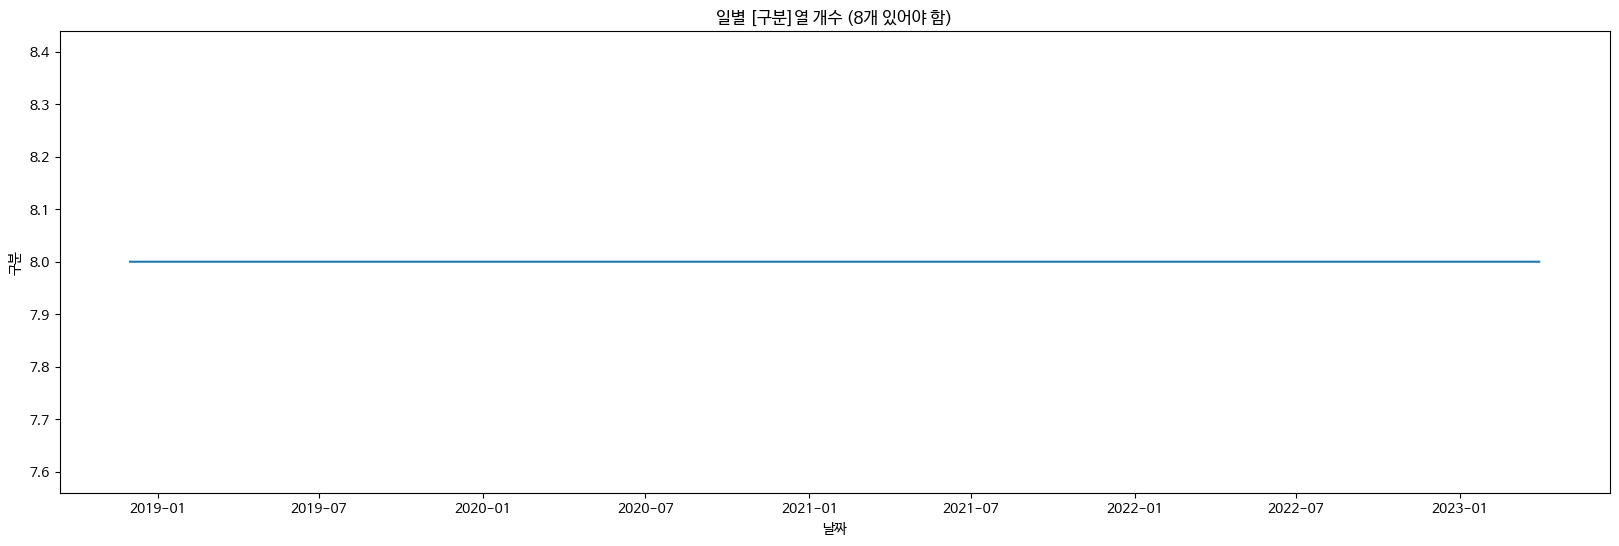

In [ ]:
#결측치 있는지 다시 확인
findnull3 = pd.DataFrame(sub.groupby('날짜').count()['구분'])
plt.figure(figsize=(20,6))
plt.title('일별 [구분]열 개수 (8개 있어야 함)')
sns.lineplot(x=findnull3.index, y='구분', data=findnull3)
plt.show()

성공!

In [ ]:
sub = sub.reset_index(); sub

,index,날짜,호선,역명,구분,00~01,01~02,02~03,04~05,05~06,...,14~15,15~16,16~17,17~18,18~19,19~20,20~21,21~22,22~23,23~24
0,0,2018-12-01,8,몽촌토성,승차,0,0,0,0,59,...,382,435,484,462,378,257,178,216,231,96
1,1,2018-12-01,8,몽촌토성,하차,9,0,0,0,29,...,433,441,501,499,448,249,198,235,200,106
2,2,2018-12-01,9,올림픽공원,순승차,0,0,0,4,20,...,348,431,484,431,328,165,145,1059,4448,245
3,3,2018-12-01,9,올림픽공원,순하차,4,0,0,4,3,...,640,831,1225,2047,2053,287,192,193,241,151
4,4,2018-12-01,5,올림픽공원,승차,1,0,0,0,25,...,287,286,383,338,249,168,126,182,1281,84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12651,14495,2022-12-12,9,한성백제,순하차,24,0,0,0,7,...,124,125,133,174,248,204,121,112,102,62
12652,14496,2022-12-12,9,올림픽공원,순승차,5,0,0,0,57,...,332,383,507,545,710,323,933,781,485,99
12653,14497,2022-12-12,9,한성백제,순승차,4,0,0,0,32,...,141,149,179,208,257,98,94,81,51,17
12654,14498,2023-03-22,9,올림픽공원,순하차,62,1,0,0,20,...,587,730,721,840,815,711,392,346,347,215


In [ ]:
sub = sub.drop('index', axis=1); sub

,날짜,호선,역명,구분,00~01,01~02,02~03,04~05,05~06,06~07,...,14~15,15~16,16~17,17~18,18~19,19~20,20~21,21~22,22~23,23~24
0,2018-12-01,8,몽촌토성,승차,0,0,0,0,59,105,...,382,435,484,462,378,257,178,216,231,96
1,2018-12-01,8,몽촌토성,하차,9,0,0,0,29,151,...,433,441,501,499,448,249,198,235,200,106
2,2018-12-01,9,올림픽공원,순승차,0,0,0,4,20,40,...,348,431,484,431,328,165,145,1059,4448,245
3,2018-12-01,9,올림픽공원,순하차,4,0,0,4,3,46,...,640,831,1225,2047,2053,287,192,193,241,151
4,2018-12-01,5,올림픽공원,승차,1,0,0,0,25,87,...,287,286,383,338,249,168,126,182,1281,84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12651,2022-12-12,9,한성백제,순하차,24,0,0,0,7,40,...,124,125,133,174,248,204,121,112,102,62
12652,2022-12-12,9,올림픽공원,순승차,5,0,0,0,57,228,...,332,383,507,545,710,323,933,781,485,99
12653,2022-12-12,9,한성백제,순승차,4,0,0,0,32,87,...,141,149,179,208,257,98,94,81,51,17
12654,2023-03-22,9,올림픽공원,순하차,62,1,0,0,20,167,...,587,730,721,840,815,711,392,346,347,215


In [ ]:
sub = sub.sort_values('날짜', ascending=True); sub

,날짜,호선,역명,구분,00~01,01~02,02~03,04~05,05~06,06~07,...,14~15,15~16,16~17,17~18,18~19,19~20,20~21,21~22,22~23,23~24
0,2018-12-01,8,몽촌토성,승차,0,0,0,0,59,105,...,382,435,484,462,378,257,178,216,231,96
1,2018-12-01,8,몽촌토성,하차,9,0,0,0,29,151,...,433,441,501,499,448,249,198,235,200,106
2,2018-12-01,9,올림픽공원,순승차,0,0,0,4,20,40,...,348,431,484,431,328,165,145,1059,4448,245
3,2018-12-01,9,올림픽공원,순하차,4,0,0,4,3,46,...,640,831,1225,2047,2053,287,192,193,241,151
4,2018-12-01,5,올림픽공원,승차,1,0,0,0,25,87,...,287,286,383,338,249,168,126,182,1281,84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12630,2023-03-31,9,올림픽공원,순승차,19,0,0,0,71,298,...,397,447,605,746,811,429,280,254,3140,221
12631,2023-03-31,9,올림픽공원,순하차,109,3,0,0,26,197,...,449,483,626,1051,2174,1909,462,392,426,298
12635,2023-03-31,9,한성백제,순하차,61,0,0,0,7,50,...,146,133,150,263,322,279,143,124,129,98
12634,2023-03-31,9,한성백제,순승차,7,0,0,0,36,117,...,123,177,207,241,384,153,118,82,75,48


In [ ]:
sub.to_csv('/content/drive/MyDrive/Colab Notebooks/DAB/지하철_결측치제거_전체.csv')

#하차, 순하차만 있는 데이터

In [ ]:
sub_out = sub.loc[(sub['구분']=='순하차')|(sub['구분']=='하차'), :]; sub_out

,날짜,호선,역명,구분,00~01,01~02,02~03,04~05,05~06,06~07,...,14~15,15~16,16~17,17~18,18~19,19~20,20~21,21~22,22~23,23~24
1,2018-12-01,8,몽촌토성,하차,9,0,0,0,29,151,...,433,441,501,499,448,249,198,235,200,106
3,2018-12-01,9,올림픽공원,순하차,4,0,0,4,3,46,...,640,831,1225,2047,2053,287,192,193,241,151
5,2018-12-01,5,올림픽공원,하차,0,0,0,0,31,130,...,323,497,710,805,1091,139,114,106,145,127
7,2018-12-01,9,한성백제,순하차,0,0,0,3,12,29,...,194,153,178,201,130,98,67,69,110,56
15,2018-12-02,9,한성백제,순하차,0,0,0,0,2,14,...,132,112,121,124,78,73,44,49,53,35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12623,2023-03-30,9,올림픽공원,순하차,82,1,0,0,31,209,...,375,365,319,603,799,741,481,379,434,270
12629,2023-03-31,8,몽촌토성,하차,82,0,0,0,83,333,...,295,355,427,576,781,580,283,275,258,160
12631,2023-03-31,9,올림픽공원,순하차,109,3,0,0,26,197,...,449,483,626,1051,2174,1909,462,392,426,298
12635,2023-03-31,9,한성백제,순하차,61,0,0,0,7,50,...,146,133,150,263,322,279,143,124,129,98


In [ ]:
sub_out['구분'].value_counts()

하차     3164
순하차    3164
Name: 구분, dtype: int64

In [ ]:
sub_out.to_csv('/content/drive/MyDrive/Colab Notebooks/DAB/지하철_결측치제거_하차.csv')

#승차, 순승차만 있는 데이터

In [ ]:
sub_in = sub.loc[(sub['구분']=='순승차')|(sub['구분']=='승차'), :]; sub_in

,날짜,호선,역명,구분,00~01,01~02,02~03,04~05,05~06,06~07,...,14~15,15~16,16~17,17~18,18~19,19~20,20~21,21~22,22~23,23~24
0,2018-12-01,8,몽촌토성,승차,0,0,0,0,59,105,...,382,435,484,462,378,257,178,216,231,96
2,2018-12-01,9,올림픽공원,순승차,0,0,0,4,20,40,...,348,431,484,431,328,165,145,1059,4448,245
4,2018-12-01,5,올림픽공원,승차,1,0,0,0,25,87,...,287,286,383,338,249,168,126,182,1281,84
6,2018-12-01,9,한성백제,순승차,0,0,0,5,22,35,...,183,250,228,228,132,89,70,79,82,10
14,2018-12-02,9,한성백제,순승차,0,0,0,0,4,26,...,183,158,177,153,66,62,65,63,36,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12626,2023-03-30,9,한성백제,순승차,5,0,0,0,39,135,...,133,187,176,224,274,99,84,94,69,17
12632,2023-03-31,5,올림픽공원,승차,10,0,0,0,39,215,...,338,451,375,497,490,238,161,111,518,86
12628,2023-03-31,8,몽촌토성,승차,59,0,0,0,57,150,...,327,422,652,727,928,474,326,304,285,128
12630,2023-03-31,9,올림픽공원,순승차,19,0,0,0,71,298,...,397,447,605,746,811,429,280,254,3140,221


In [ ]:
sub_in['구분'].value_counts()

승차     3164
순승차    3164
Name: 구분, dtype: int64

In [ ]:
sub_in.to_csv('/content/drive/MyDrive/Colab Notebooks/DAB/지하철_결측치제거_승차.csv')